In [2]:
import time
import h5py
import matplotlib.pyplot as plt
from scipy import ndimage
from dnn_app_utils_v3 import *
from public_tests import *
import os
import json
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras import layers, models

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [8]:
import os
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
from shutil import copyfile

# Paths
dataset_path = r"D:\ML Projects\CNN Classification\W4A2\Classifier\RealWaste"  # Original dataset directory (class subfolders)
output_path = r"D:\ML Projects\CNN Classification\W4A2\Classifier\Augmented_RealWaste"  # Augmented dataset directory

# Parameters
min_images_per_class = 318  # Minimum number of images to select per class
target_images_per_class = 1000  # Target images after augmentation per class

# Create the augmented dataset directory
os.makedirs(output_path, exist_ok=True)

# Initialize the data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Process each class folder
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    aug_dir = os.path.join(output_path, class_name)
    os.makedirs(aug_dir, exist_ok=True)  # Create the folder for augmented images
    
    # Get all images in the class directory
    images = os.listdir(class_dir)
    
    # Step 1: Select 318 random images
    selected_images = random.sample(images, min(min_images_per_class, len(images)))
    
    # Copy the selected images to the augmented folder
    for img in selected_images:
        copyfile(os.path.join(class_dir, img), os.path.join(aug_dir, img))
    
    # Step 2: Apply augmentation to reach the target number of images
    current_images = os.listdir(aug_dir)  # Updated list of images in the augmented folder
    while len(current_images) < target_images_per_class:
        for img_name in current_images:
            img_path = os.path.join(aug_dir, img_name)
            img = load_img(img_path)  # Load the image
            img_array = img_to_array(img)  # Convert to array
            img_array = img_array.reshape((1,) + img_array.shape)  # Reshape for the generator
            
            # Generate augmented images
            i = 0
            for batch in datagen.flow(img_array, batch_size=1,
                                      save_to_dir=aug_dir,
                                      save_prefix="aug",
                                      save_format="jpeg"):
                i += 1
                if len(os.listdir(aug_dir)) >= target_images_per_class:
                    break  # Stop if target is reached
                if i >= 5:  # Limit augmentation iterations per image
                    break
        current_images = os.listdir(aug_dir)  # Refresh list of images

print("Augmentation completed!")


Augmentation completed!


In [9]:
# Set your directory path where the images are stored
image_dir = r'D:\ML Projects\CNN Classification\W4A2\Classifier\Augmented_RealWaste'
data = []

# Iterate through each type of waste folder
for waste_type in os.listdir(image_dir):
    type_path = os.path.join(image_dir, waste_type)
    if os.path.isdir(type_path):
        # Iterate through each image in the waste type folder
        for image_name in os.listdir(type_path):
            if image_name.endswith(('.png', '.jpg', '.jpeg')):  # Add any other image formats as needed
                image_path = os.path.join(type_path, image_name)
                data.append({
                    'file_name': image_name,
                    'path': image_path,
                    'type': waste_type
                })

# Shuffle the dataset
np.random.seed(42)  # For reproducibility
np.random.shuffle(data)

# Create lists for X and y
X = [entry['path'] for entry in data]  # Image paths
y = [entry['type'] for entry in data]   # Corresponding labels

# Encode the labels as integers and store the names
unique_classes = list(set(y))
class_mapping = {cls: idx for idx, cls in enumerate(unique_classes)}
y_encoded = [class_mapping[label] for label in y]
y_names = [unique_classes[label] for label in y_encoded]  # Store original names corresponding to encoded labels

# Split the data into training (60%), validation (20%), and testing (20%)
train_x, temp_x, train_y, temp_y, train_y_names, temp_y_names = train_test_split(X, y_encoded, y_names, test_size=0.4, random_state=42)
val_x, test_x, val_y, test_y, val_y_names, test_y_names = train_test_split(temp_x, temp_y, temp_y_names, test_size=0.5, random_state=42)

# Create a dataset dictionary
dataset = {
    'train': {'X': train_x, 'y': train_y, 'y_names': train_y_names},
    'validation': {'X': val_x, 'y': val_y, 'y_names': val_y_names},
    'test': {'X': test_x, 'y': test_y, 'y_names': test_y_names},
    'class_mapping': class_mapping  # Include class mapping for reference
}

# Save the dataset to a JSON file
json_file_path = 'waste_images_dataset_split.json'
with open(json_file_path, 'w') as json_file:
    json.dump(dataset, json_file, indent=4)

print(f"Dataset split into train, validation, and test sets and saved to {json_file_path}.")


Dataset split into train, validation, and test sets and saved to waste_images_dataset_split.json.


Image shape: (277, 277, 3)
y = 5. It's a Cardboard picture.


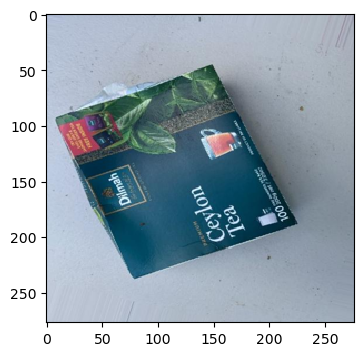

In [10]:
# Load the dataset from the JSON file
json_file_path = 'waste_images_dataset_split.json'

with open(json_file_path, 'r') as json_file:
    dataset = json.load(json_file)

# Example of using the training set
train_data = dataset['train']
train_x = train_data['X']  # Image paths
train_y = train_data['y']   # Labels

# Choose an index to display an image
index = 389
num_px = 277

# Load the image from the specified path
image_path = train_x[index]
image = Image.open(image_path).resize((num_px, num_px))  # Resize as necessary
plt.imshow(image)

# Print the shape of the image
print("Image shape:", np.array(image).shape)

# Get the corresponding label
label = train_y_names[index]
label_number = train_y[index]
print("y = " + str(label_number) + ". It's a " + label + " picture.")
classes = ["Glass", "Plastic", "Metal", "Miscellaneous Trash", "Cardboard", "Food Organics", "Textile Trash", "Paper", "Vegetation"]


In [11]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from PIL import Image
import json

# Load the dataset from the JSON file
json_file_path = 'waste_images_dataset_split.json'

with open(json_file_path, 'r') as json_file:
    dataset = json.load(json_file)

# Extract the training and testing data
train_data = dataset['train']
test_data = dataset['test']

# Set the number of pixels for resizing images
num_px = 256  # Example pixel size for resizing images

# Prepare the data for exploration with names included
train_x = np.array([np.array(Image.open(image_path).resize((num_px, num_px))) / 255.0 for image_path in train_data['X']])
train_y = np.array(train_data['y'])
train_y_names = np.array(train_data['y_names'])  # Add names for training set

test_x = np.array([np.array(Image.open(image_path).resize((num_px, num_px))) / 255.0 for image_path in test_data['X']])
test_y = np.array(test_data['y'])
test_y_names = np.array(test_data['y_names'])  # Add names for testing set

# One-hot encode the labels
encoder = OneHotEncoder(sparse_output=False, categories='auto')  # Replace sparse with sparse_output
train_y_one_hot = encoder.fit_transform(train_y.reshape(-1, 1))  # Reshape for encoder
test_y_one_hot = encoder.transform(test_y.reshape(-1, 1))  # Use transform on test set

# Explore your dataset
m_train = train_x.shape[0]
num_px = train_x.shape[1]  # Assuming square images
m_test = test_x.shape[0]

print("Number of training examples: " + str(m_train))
print("Number of testing examples: " + str(m_test))
print("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print("train_x shape: " + str(train_x.shape))
print("train_y shape (original): " + str(train_y.shape))
print("train_y shape (one-hot): " + str(train_y_one_hot.shape))
print("test_x shape: " + str(test_x.shape))
print("test_y shape (original): " + str(test_y.shape))
print("test_y shape (one-hot): " + str(test_y_one_hot.shape))


Number of training examples: 6272
Number of testing examples: 2091
Each image is of size: (256, 256, 3)
train_x shape: (6272, 256, 256, 3)
train_y shape (original): (6272,)
train_y shape (one-hot): (6272, 9)
test_x shape: (2091, 256, 256, 3)
test_y shape (original): (2091,)
test_y shape (one-hot): (2091, 9)


In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models

# Load the InceptionV3 model with pre-trained ImageNet weights
GoogleNet_base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
num_classes = 9

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(GoogleNet_base_model.output)  # Global average pooling instead of flattening
x = layers.Dense(128, activation='relu')(x)            # Fully connected layer
output = layers.Dense(num_classes, activation='softmax')(x)  # Output layer

# Build the new model
GoogleNet_model = models.Model(inputs=GoogleNet_base_model.input, outputs=output)

# Summary
GoogleNet_model.summary()


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

# Load the ResNet50 model with pre-trained ImageNet weights
ResNet_base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
num_classes = 9

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(ResNet_base_model.output)  # Global average pooling
x = layers.Dense(128, activation='relu')(x)            # Fully connected layer
output = layers.Dense(num_classes, activation='softmax')(x)  # Output layer

# Build the new model
ResNet_model = models.Model(inputs=ResNet_base_model.input, outputs=output)

# Summary
ResNet_model.summary()

In [18]:
print("Shape of train_x:", train_x.shape)
print("Shape of train_y:", train_y_one_hot.shape)

num_train_x = train_x.shape[0]
print(num_train_x)
num_test_x = test_x.shape[0]
print(num_test_x)

Shape of train_x: (6272, 256, 256, 3)
Shape of train_y: (6272, 9)
6272
2091


In [25]:
# You can keep train_y and train_y_names as is:
train_y = train_y.reshape(num_train_x,)  # Keep it 1D for single label representation
train_y_names = train_y_names.reshape(num_train_x,)  # Keep it 1D for single label representation

# You do not need to reshape test_y and test_y_names unless you have a specific reason to do so
test_y_names = test_y_names.reshape(num_test_x,)  # Keep it 1D for single label representation
test_y = test_y.reshape(num_test_x,)  # Keep it 1D for single label representation

# If you also want one-hot encoding for test_y:
test_y_one_hot = encoder.transform(test_y.reshape(-1, 1))  # Convert to one-hot for test set

# Verify shapes
print("train_y shape:", train_y.shape)
print("train_y_names shape:", train_y_names.shape)
print("train_y_one_hot shape:", train_y_one_hot.shape)
print("test_y shape:", test_y.shape)
print("test_y_names shape:", test_y_names.shape)
print("test_y_one_hot shape:", test_y_one_hot.shape)


train_y shape: (6272,)
train_y_names shape: (6272,)
train_y_one_hot shape: (6272, 9)
test_y shape: (2091,)
test_y_names shape: (2091,)
test_y_one_hot shape: (2091, 9)


In [30]:
# Optional: Freeze the base model layers
for layer in GoogleNet_model.layers:
    layer.trainable = False

# Compile the model
GoogleNet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
# Train the model
history_GoogleNet = GoogleNet_model.fit(train_x, train_y_one_hot, epochs=10, batch_size=16, validation_data=(test_x, test_y_one_hot))

Epoch 1/10


C:\Users\MSI KATANA\AppData\Roaming\Python\Python311\site-packages\keras\src\backend\tensorflow\trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


 32/392 ━━━━━━━━━━━━━━━━━━━━ 5:46 961ms/step - accuracy: 0.1340 - loss: 2.3376

KeyboardInterrupt: 

In [ ]:
# Optional: Freeze the base model layers
for layer in ResNet_base_model.layers:
    layer.trainable = False

# Compile the model
ResNet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history_ResNet = ResNet_model.fit(train_x, train_y_one_hot, epochs=10, batch_size=32, validation_data=(test_x, test_y_one_hot))

Epoch 1/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 151s 557ms/step - accuracy: 1.0000 - loss: 0.0060 - val_accuracy: 0.9525 - val_loss: 0.1253
Epoch 2/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 136s 504ms/step - accuracy: 1.0000 - loss: 0.0047 - val_accuracy: 0.9563 - val_loss: 0.1193
Epoch 3/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 136s 504ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 0.9570 - val_loss: 0.1131
Epoch 4/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 137s 508ms/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 0.9609 - val_loss: 0.1086
Epoch 5/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 138s 512ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.9612 - val_loss: 0.1129
Epoch 6/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 149s 556ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.9605 - val_loss: 0.1063
Epoch 7/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 138s 511ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.9595 - val_loss: 0.1116
Epoch 8/10
269/269 ━━━━━━━━━━━━━━━━━━━━ 138s 514ms/step - accuracy: 1.0000 -

['Glass', 'Plastic', 'Metal', 'Miscellaneous Trash', 'Cardboard', 'Food Organics', 'Textile Trash', 'Paper', 'Vegetation']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


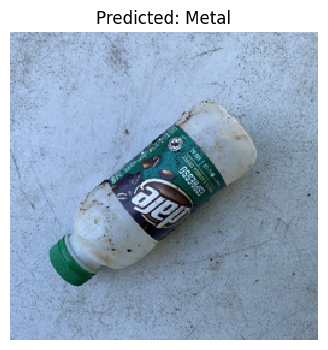

Predicted class index: 2
Predicted class name: "Metal"


In [13]:
def predict_class(image_path, model, class_names, num_px=256):
    """
    Function to predict the class of an image and return the class name, while displaying the image.
    
    Parameters:
    - image_path: str, path to the image to be predicted.
    - model: trained Keras model.
    - class_names: list of str, names of classes corresponding to model output indices.
    - num_px: int, pixel dimension to resize the image to (assuming square images).

    Returns:
    - predicted_class_name: str, name of the predicted class.
    """
    # Load and preprocess the image
    image = Image.open(image_path).resize((num_px, num_px))
    image_array = np.array(image) / 255.0  # Normalize pixel values
    image_input = image_array.reshape((1, num_px, num_px, 3))  # Add batch dimension

    # Predict using the model
    predictions = model.predict(image_input)
    
    # Get the index of the highest probability
    predicted_class_index = np.argmax(predictions[0])
    
    # Retrieve the class name from class_names using the predicted index
    predicted_class_name = class_names[predicted_class_index]

    # Display the image with the predicted class name
    plt.imshow(image_array)
    plt.title(f"Predicted: {predicted_class_name}")
    plt.axis('off')
    plt.show()

    # Print the prediction result
    print(f"Predicted class index: {predicted_class_index}")
    print(f"Predicted class name: \"{predicted_class_name}\"")
    
    return predicted_class_name

# Example usage:
# Assuming `train_y_names` holds the names of the classes corresponding to indices 0–8.
print(classes)
image_path = "D:\ML Projects\CNN Classification\W4A2\Classifier\images\Plastic.jpg"  # Replace with your image path
predicted_class_name = predict_class(image_path, model, classes)
